In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from activ.pipeline import score_clusters
import matplotlib.pyplot as plt
import scipy
import h5py
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as _sch
from collections import Counter
from activ import load_data
import pandas as pd
from math import ceil
import pandas as pd
from matplotlib import cm

In [2]:
fulldata = pd.read_csv('/Users/ahyeon/Desktop/TBIanalysis/data/preprocessed_data_matrix.csv', encoding = "ISO-8859-1")
fulldata = fulldata.fillna(-1)
fulldata.shape

(586, 919)

In [3]:
data = load_data()
nmfdata = load_data(uoinmf=True)
oc_features = data.outcome_features
oc_bases = nmfdata.outcome_bases
oc = data.outcomes
oc_bases.shape

(6, 177)

In [6]:
file = '/Users/ahyeon/Desktop/activ misc/sweep_u2-10_c2-50_i50_raw-oc-cluster_uoinmf-bm-predict/umap_clustering_sweep.h5'

In [7]:
f = h5py.File(file, 'r')

In [8]:
umap_dims = f['umap_dimensions'][:]
score = f['score'][:]
norm_score = f['norm_score'][:]
clusters = f['clusters'][:]
cluster_sizes = f['cluster_sizes'][:]
emb = f['umap_embeddings'][:]
scale = f['umap_embeddings_dimscale'][:][:54]

In [9]:
for dim in umap_dims:
    all_dmat = np.zeros((30381,50))
    for x in range(emb.shape[0]):
        dmat = pdist(emb[x][:,scale==dim], metric='mahalanobis')
        all_dmat[:,x] = dmat
    mean = all_dmat.mean(axis=1)
mean.shape

(30381,)

In [10]:
def calc_entropy(gose_scores):
    probs = np.array(list(Counter(gose_scores).values()))/len(gose_scores)
    return entropy(probs, base=2.0)

In [11]:
def entropy_across_clusters(cluster_sizes, data):
    values = []
    tree = _sch.linkage(mean, method='ward')
    labels = _sch.cut_tree(tree, cluster_sizes)
    for ii,c in enumerate(cluster_sizes):
        entropies = []
        for label in np.unique(labels[:,ii]):
            scores = data[labels[:,ii]==label]
            ent = calc_entropy(scores)
            entropies.append(ent)
        v = np.mean(entropies)
        values.append(v)
    return values

In [12]:
# leverage scores
leveragescores = pd.read_csv('/Users/ahyeon/Desktop/activ misc/fullfeaturestable.csv', encoding = "ISO-8859-1")
scores = leveragescores['Leverage Score']
leveragescores
features = leveragescores['0%']

In [19]:
len(features)

177

In [18]:
# top 10
plt.figure(figsize=(6,6))
colormap = cm.Greys_r
colors = [colormap(i) for i in np.linspace(0, 0.9, 10)]
for ii,i in enumerate(features[:10]):
    data = oc[:,ii]
    score = float(round(scores[ii],3))
    plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, data), '.', label=i+ ': ' + str(score), color=colors[ii])
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Entropy')
    plt.title('Num Clusters vs Entropy for Top 10 Outcomes')
plt.savefig('/Users/ahyeon/Desktop/activ misc/top10_entropy.pdf',bbox_inches='tight')

SyntaxError: invalid syntax (<ipython-input-18-f2b7ca78a869>, line 8)

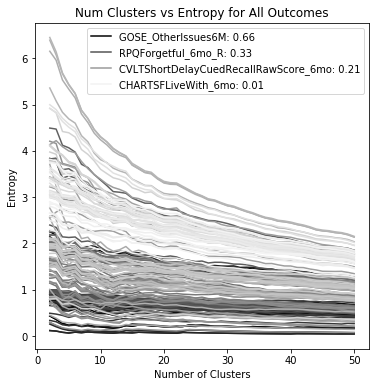

In [22]:
# all features

plt.figure(figsize=(6,6))
colormap = cm.Greys_r
colors = [colormap(i) for i in np.linspace(0, 0.9, 177)]
include = [0,50,100,176,177]
for ii,i in enumerate(features):
    data = oc[:,ii]
    score = float(round(scores[ii],3))
    plt.gray()
    plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, data), color=colors[ii])
    plt.xlabel('Number of Clusters')
    plt.ylabel('Entropy')
    plt.title('Num Clusters vs Entropy for All Outcomes')
    if ii in include:
        plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, data), color=colors[ii], label=i+ ': ' + str(score))
        plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/all_entropy.pdf',bbox_inches='tight')